### The loss and accuracy data for the model is in the training section of this notebook

## Introduction

In this tutorial, we will build a character-level text autocomplete model using a Recurrent Neural Network (RNN) in PyTorch. We will train the model on the text from "warandpeace.txt". This project will help you understand how RNNs can be implemented for text generation tasks and their application in building your own autocomplete model.


## Importing Necessary Libraries

In [1]:
# This is Cell #1

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import random
import re
import matplotlib.pyplot as plt
import os

## Setting Up the Device

In [2]:
# This is Cell #2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading and Preprocessing the Data

Now it is time to prepare our training data.


In [3]:
# This is Cell #3

def read_file(filename):
    with open(filename, "r", encoding="utf-8") as file:
        text = file.read().lower()
        # Keep only lowercase letters and standard punctuation (.,!?;:()[])
        text = re.sub(r'[^a-z.,!?;:()\[\] ]+', '', text)
    return text



### Here we will train our model with a simple sequence

We will start by training our model with a simple sequence and repettitive sequence such as `"abcdefghijklmnopqrstuvwxyzabcdef..."`, and we will see if our RNN is capable of learning that pattern or not. This will help you easily verify if your RNN is working correctly or not.

In [ ]:
# This is Cell #4
sequence = "abcdefghijklmnopqrstuvwxyz" * 100

In [5]:
sequence = read_file('warandpeace.txt')

## Create Character Mappings

Creating character mappings is essential because RNNs require numerical input to process data. By mapping each unique character to an index and creating a reverse mapping, we convert text data into numerical sequences that the model can understand. This step allows us to encode input text for training and decode the model's output back into readable characters during text generation.



In [6]:
# This is Cell #5

#TODO: Create a list of unique characters from the text sequence
vocab = list(set(sequence))

#TODO: Create two dictionaries for character-index mappings that map each character in vocab to a unique index and vice versa
char_to_idx = {vocab[i]: i for i in range(len(vocab))}
idx_to_char = {i: vocab[i] for i in range(len(vocab))}

#TODO: Convert the entire text based data into numerical data
data = [char_to_idx[char] for char in sequence]


## Defining the CharDataset Class

Now we will create a custom dataset class to generate sequences and targets for training

Creating a custom `CharDataset` class is crucial because it prepares our text data into input sequences and target sequences that the RNN can learn from. By organizing the data this way, we can efficiently feed batches of sequences into the model during training, allowing it to learn the patterns of character sequences in the text.

In [7]:
# This is Cell #6

class CharDataset(Dataset):
    def __init__(self, data, sequence_length, stride, vocab_size):
        self.data = data
        self.sequence_length = sequence_length
        self.stride = stride
        self.vocab_size = vocab_size
        self.sequences = []
        self.targets = []

        # Create overlapping sequences with stride
        for i in range(0, len(data) - sequence_length, stride):
            self.sequences.append(data[i:i + sequence_length])
            self.targets.append(data[i + 1:i + sequence_length + 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return sequence, target


## Setting Hyperparameters

Now we will set our model's hyperparameters for our training process

Setting hyperparameters is important because they define the model's architecture and training behavior. They determine how the RNN processes data, learns patterns, and how quickly it converges during training. Properly chosen hyperparameters can significantly improve model performance and is a key step in training of models

Set the following hyperparameters for your model in the code cell below:
`sequence_length`, `stride`, `embedding_dim`, `hidden_size`, `num_layers`, `learning_rate`, `num_epochs`, `batch_size`, `vocab_size`.

In [8]:
# This is Cell #7

#TODO: Set your model's hyperparameters

sequence_length = 100  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 500     # Number of features in the hidden state of the RNN
learning_rate = 1e-3  # Learning rate for the optimizer
num_epochs = 10        # Number of epochs to train
batch_size = 64        # Batch size for training
vocab_size = len(vocab)
input_size = len(vocab)
output_size = len(vocab)




In [ ]:
# This is Cell #7

#TODO: Set your model's hyperparameters

sequence_length = 200  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 100     # Number of features in the hidden state of the RNN
learning_rate = 1e-3  # Learning rate for the optimizer
num_epochs = 2        # Number of epochs to train
batch_size = 64        # Batch size for training
vocab_size = len(vocab)
input_size = len(vocab)
output_size = len(vocab)
model_path = '/content/drive/MyDrive/text_383/warandpeace3.pth'


In [ ]:
sequence_length = 1000  # Length of each input sequence
stride = 10            # Stride for creating sequences
embedding_dim = 30     # Dimension of character embeddings
hidden_size = 20     # Number of features in the hidden state of the RNN
learning_rate = 200  # Learning rate for the optimizer
num_epochs = 40        # Number of epochs to train
batch_size = 64        # Batch size for training

After you have set your hyperparameters in the code cell above, very breifly tell what is the role of each of the hyperparameter that you have defined above.

TODO: Explain below
> Here
>

## Splitting Data into Training and Testing Sets

By now at this point in class, I'm confident that you know why we do this, so I'm not gonna say a lot here, let's jump right into the todo.

In [9]:
# This is Cell #8

data_tensor = torch.tensor(data, dtype=torch.long)

#TODO: Convert the data into a pytorch tensor and split the data into 90:10 ratio
train_size = int(data_tensor.size(0) * 0.9)
train_data, test_data = data_tensor.split([train_size, data_tensor.size(0) - train_size])

## Creating Data Loaders

Now we will create data loaders for easy batching during training and testing.

Creating data loaders is essential to batch the data during training and testing. Batching allows the RNN to process multiple sequences in parallel, which speeds up training and makes better use of computational resources.
We will also use Data loaders to shuffle the batched data, which is important for training models that generalize well.

Make sure to set `drop_last=True`

In [10]:
# This is Cell #9

train_dataset = CharDataset(train_data, sequence_length, stride, vocab_size)
test_dataset = CharDataset(test_data, sequence_length, stride, vocab_size)

#TODO: Initialize the training and testing data loader with batching and shuffling equal to True for training (and shuffling = False for testing)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

total_batches = len(train_loader)

In [ ]:
total_batches

4387

## Defining the RNN Model

Here we will define our character-level RNN model.

In [11]:
# This is Cell #10

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_dim=30):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_dim)
        self.W_e = nn.Parameter(torch.randn(hidden_size, embedding_dim) * 0.01)  # Smaller std
        self.b_e = nn.Parameter(torch.zeros(hidden_size))
        self.W_h = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)  # Smaller std
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        #TODO: set the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """
        x in [b, l] # b is batch_size and l is sequence length
        """
        x_embed = self.embedding(x)  # [b=batch_size, l=sequence_length, e=embedding_dim]
        b, l, _ = x_embed.size()
        x_embed = x_embed.transpose(0, 1) # [l, b, e]
        if hidden is None:
            h_t_minus_1 = self.init_hidden(b)
        else:
            h_t_minus_1 = hidden
        output = []
        for t in range(l):
            # RNN equation from the lecture
            # We add a bias as well to expand the range of learnable functions
            h_t = torch.tanh(x_embed[t] @ self.W_e.T + self.b_e + h_t_minus_1 @ self.W_h.T + self.b_h) # [b, e]
            output.append(h_t)
            h_t_minus_1 = h_t
        output = torch.stack(output) # [l, b, e]
        output = output.transpose(0, 1) # [b, l, e]
        final_hidden = h_t.clone() # [b, h]
        logits = self.fc(output) # [b, l, vocab_size=v]
        return logits, final_hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(device)


For a basic high level understanding of what is the CharRNN model that you just defined above, it consists of an embedding layer, an RNN layer, and a fully connected layer. Then embedding layer converts character indices into embeddings. Then RNN processes the embeddings and captures sequential information. Then finally the fully connected layer maps the RNN outputs to the vocabulary size for character prediction.


# Initializing the Model, Loss Function, and Optimizer

Now we will create an instance of the model that we just defined above and set up the loss function and optimizer. Then we will define a loss function, that evaluates the model's prediction against the true targets, and attaches a cost (number) on how good/bad the model is doing. During our training process, it is this cost that we try to minimize by tweaking the weights of the network.

Then we will set up an optimizer, which will update the model's parameters based on the loss returned by the our loss function. This is how our model will learn over time.


In [14]:
# This is Cell #12

#TODO: Initialize your RNN model
model = CharRNN(input_size, hidden_size, output_size, embedding_dim)
model.to(device)
#TODO: Define the loss function (use cross entropy loss)
criterion = nn.CrossEntropyLoss()

#TODO: Initialize your optimizer passing your model parameters and training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Training the Model

Now finally, after all the setup that we have done, we can train our RNN.

A basic idea high level idea of what we will do here is we will loop over epochs and batches to train the model.
We will Initialize the hidden state at the beginning of each epoch. For each batch, we will reset the gradients, perform a forward pass, compute the loss, perform backpropagation, and update the model parameters. Then we detach the hidden state to prevent gradients from backpropagating through previous batches. We ill repeat this process for each batch. And finally we will calculate the average loss and accuracy for each epoch.
By performing forward and backward passes, calculating loss, and updating the model parameters, we enable the RNN to improve its predictions with each epoch.

In [ ]:
device

device(type='cuda')

Epoch 1/10:   0%|          | 0/4387 [00:00<?, ?it/s]<ipython-input-7-c998a511bd21>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
<ipython-input-7-c998a511bd21>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.targets[idx], dtype=torch.long)
Epoch 1/10: 100%|██████████| 4387/4387 [21:40<00:00,  3.37it/s]


Epoch [1/10], Loss: 1.3125, Accuracy: 60.96%


Epoch 2/10: 100%|██████████| 4387/4387 [22:22<00:00,  3.27it/s]


Epoch [2/10], Loss: 1.2785, Accuracy: 61.92%


Epoch 3/10: 100%|██████████| 4387/4387 [21:57<00:00,  3.33it/s]


Epoch [3/10], Loss: 1.2636, Accuracy: 62.34%


Epoch 4/10: 100%|██████████| 4387/4387 [21:51<00:00,  3.35it/s]


Epoch [4/10], Loss: 1.2555, Accuracy: 62.57%


Epoch 5/10: 100%|██████████| 4387/4387 [21:50<00:00,  3.35it/s]


Epoch [5/10], Loss: 1.2507, Accuracy: 62.70%


Epoch 6/10: 100%|██████████| 4387/4387 [21:45<00:00,  3.36it/s]


Epoch [6/10], Loss: 1.2479, Accuracy: 62.79%


Epoch 7/10: 100%|██████████| 4387/4387 [21:45<00:00,  3.36it/s]


Epoch [7/10], Loss: 1.2464, Accuracy: 62.82%


Epoch 8/10: 100%|██████████| 4387/4387 [21:38<00:00,  3.38it/s]


Epoch [8/10], Loss: 1.2453, Accuracy: 62.84%


Epoch 9/10: 100%|██████████| 4387/4387 [21:41<00:00,  3.37it/s]


Epoch [9/10], Loss: 1.2449, Accuracy: 62.86%


Epoch 10/10: 100%|██████████| 4387/4387 [21:51<00:00,  3.35it/s]

Epoch [10/10], Loss: 1.2449, Accuracy: 62.85%


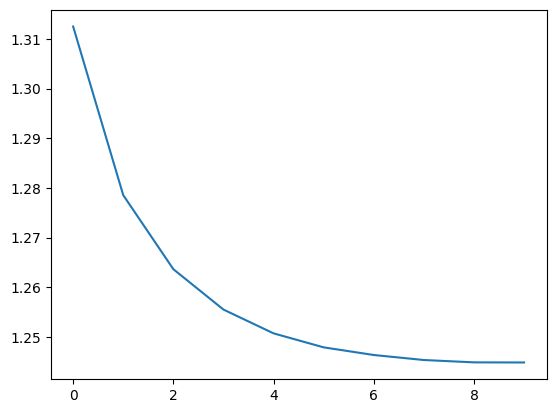

In [17]:
# This is Cell #13

losses = []
for epoch in range(num_epochs):
    total_loss, correct_predictions, total_predictions = 0, 0, 0

    hidden = model.init_hidden(batch_size)
    for batch_idx, (batch_inputs, batch_targets) in tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        output, hidden = model(batch_inputs, hidden)
        hidden = hidden.detach()
        #print(batch_inputs.shape)
        #print([idx_to_char[int(c)] for c in torch.argmax(output, dim=1)[0]] )
        #for i in range(10):
        #    print([idx_to_char[int(c)] for c in batch_inputs[i]])
        loss = criterion(output.view(-1, output_size), batch_targets.view(-1))  # Flatten the outputs and targets for CrossEntropyLoss
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.no_grad():
            # Calculate accuracy
            _, predicted_indices = torch.max(output, dim=2)  # Predicted characters

            correct_predictions += (predicted_indices == batch_targets).sum().item()
            total_predictions += batch_targets.size(0) * batch_targets.size(1)  # Total items in this batch

        total_loss += loss.item()
    torch.save(model.state_dict(), os.path.join(model_path, f'epoch{epoch}.pth'))
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions * 100  # Convert to percentage
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    losses.append(avg_loss)
plt.plot(losses)


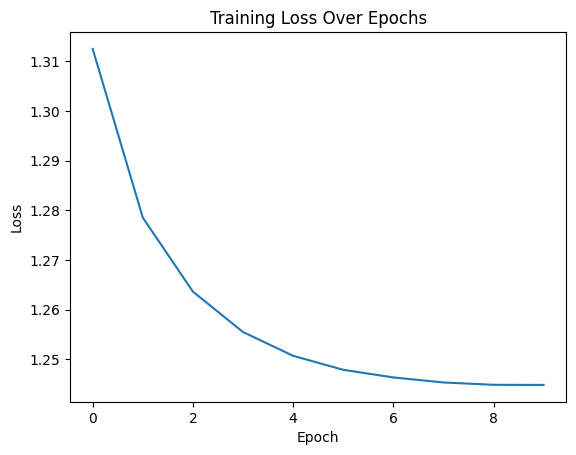

In [23]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [29]:
print(input_size)

37


In [12]:
# Inference
model = CharRNN(input_size, hidden_size, output_size, embedding_dim)
model.to(device)
model.load_state_dict(torch.load("epoch9.pth", weights_only=True))
model.eval()
test_input = 'everyd'
input_indices = [char_to_idx[c] for c in test_input]
input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
hidden = model.init_hidden(batch_size=1)
generated_str = test_input
with torch.no_grad():
    for i in range(100):
        output, hidden = model(input_tensor, hidden)
        last_output = output[:, -1, :]
        predicted_idx = torch.argmax(last_output)
        predicted_char = idx_to_char[int(predicted_idx)]
        generated_str += predicted_char
        input_indices = [char_to_idx[c] for c in generated_str]
        input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
        print(generated_str)

everydn
everydnm
everydnmt
everydnmt[
everydnmt[o
everydnmt[om
everydnmt[omt
everydnmt[omtf
everydnmt[omtfk
everydnmt[omtfky
everydnmt[omtfkyg
everydnmt[omtfkyg[
everydnmt[omtfkyg[m
everydnmt[omtfkyg[mw
everydnmt[omtfkyg[mww
everydnmt[omtfkyg[mwwt
everydnmt[omtfkyg[mwwth
everydnmt[omtfkyg[mwwthq
everydnmt[omtfkyg[mwwthqw
everydnmt[omtfkyg[mwwthqwt
everydnmt[omtfkyg[mwwthqwtw
everydnmt[omtfkyg[mwwthqwtwq
everydnmt[omtfkyg[mwwthqwtwql
everydnmt[omtfkyg[mwwthqwtwql.
everydnmt[omtfkyg[mwwthqwtwql.g
everydnmt[omtfkyg[mwwthqwtwql.gn
everydnmt[omtfkyg[mwwthqwtwql.gnt
everydnmt[omtfkyg[mwwthqwtwql.gnt[
everydnmt[omtfkyg[mwwthqwtwql.gnt[o
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[t
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[to
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[tom
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[tomt
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[tomth
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[tomthq
everydnmt[omtfkyg[mwwthqwtwql.gnt[oq[t

## Check your loss

The training loss of your model when trained with a simple sequence like `"abcdefghijklmnopqrstuvwxyz" * 100` should be extremely close to zero. If that's not the case, go back and fix your bugs ;)

If you have acheived a training loss of 0 or extremley close to 0, then congratulations, lets move on to train your model with a bit more complicated sequence. That is our old favorite book, `warandpeace.txt`.

### Read the `warandpeace.txt` file

In [ ]:
# This is Cell #14

sequence = read_file('warandpeace.txt')

### Now Follow the instructions

1. Re-run Cell #5 to re-create character mappings for `warandpeace.txt`
2. Re-run Cell #7 to re-initialize hyperparameters
3. Re-run Cell #8 to split and create training and testing data with `warandpeace.txt` as your corpus
4. Re-run Cell #9 to set up data loaders with `warandpeace.txt` data
5. Re-run Cell #12 to re-initialize a new model object (maybe ask yourself why can't you use the previous model that was trained on the simple `"abc..."` corpus)
6. Re-run Cell #13 to train the new model with `warandpeace.txt` data.
   

## Evaluating the Model

After training, we evaluate the model on the test data.

In [ ]:
# This is Cell #15

with torch.no_grad():
    #TODO: Write the testing loop for your trained model by refering to the training loop code given to you above


    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

## Generating Text with the Trained Model

In this part of the assignment, your task is to implement the `generate_text` function, which uses a trained RNN model to generate text character-by-character, continuing from a given input. The function will produce an extended sequence by repeatedly predicting and appending the next character to the input.

### What the function is supposed to do?

1. Take an initial input text of length `n` from the user, convert it into indices using a predefined vocabulary (char_to_idx).
2. Use a trained model to predict the next character in the sequence.
3. Append the predicted character to the input, extend the input sequence, and repeat the process until `k` additional characters are generated.
4. Return the generated text, including the original input and the newly predicted characters.


In [ ]:
# This is Cell #16

def sample_from_output(logits, temperature=1.0):
    """
    Sample from the logits with temperature scaling.
    logits: Tensor of shape [batch_size, vocab_size] (raw scores, before softmax)
    temperature: a float controlling the randomness (higher = more random)
    """
    # Apply temperature scaling to logits (increase randomness with higher values)
    scaled_logits = logits / temperature  # Scale the logits by temperature
    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(scaled_logits, dim=1)

    # Sample from the probability distribution
    sampled_idx = torch.multinomial(probabilities, 1)  # Sample one index from the probability distribution
    return sampled_idx

def generate_text(model, start_text, n, k, temperature=1.0):
    """
        model: The trained RNN model used for character prediction.
        start_text: The initial string of length `n` provided by the user to start the generation.
        n: The length of the initial input sequence.
        k: The number of additional characters to generate.
        temperature: Optional
        A scaling factor for randomness in predictions. Higher values (e.g., >1) make
            predictions more random, while lower values (e.g., <1) make predictions more deterministic.
            Default is 1.0.
    """
    start_text = start_text.lower()
    #TODO: Implement the rest of the generate_text function


    return generated_text

print("Training complete. Now you can generate text.")
while True:
    start_text = input("Enter the initial text (n characters, or 'exit' to quit): ")

    if start_text.lower() == 'exit':
        print("Exiting...")
        break

    n = len(start_text)
    k = int(input("Enter the number of characters to generate: "))
    temperature_input = input("Enter the temperature value (1.0 is default, >1 is more random): ")
    temperature = float(temperature_input) if temperature_input else 1.0

    completed_text = generate_text(model, start_text, n, k, temperature)

    print(f"Generated text: {completed_text}")

## Report section

In your report, describe your experiments and observations when training the model with two datasets: (1) the sequence `"abcdefghijklmnopqrstuvwxyz" * 100` and (2) the text from `warandpeace.txt`. Include the final loss values for both datasets and discuss how the generated text differed between the two. Explain the impact of changing the `temperature` parameter on the text generation, and provide examples. Reflect on the challenges you faced, your thought process during implementation, and the key insights you gained about RNNs and sequence modeling.
